<a href="https://colab.research.google.com/github/abdalrahmenyousifMohamed/NLP/blob/main/fttransformer_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep


In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams.update({'font.size': 15})

## Download Data

In [5]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [6]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [7]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']

FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)
LABEL = 'income_bracket'

In [8]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K'))
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))
train_data[LABEL].mean(), test_data[LABEL].mean()

(0.2408095574460244, 0.23621176759611842)

In [10]:
test_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,0
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,0
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,1
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,1


In [11]:
test_data = test_data.iloc[1:, :] # drop invalid row

In [12]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [13]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [14]:
X_train[NUMERIC_FEATURES]

,age,education_num,capital_gain,capital_loss,hours_per_week
7468,54.0,9.0,0.0,0.0,35.0
17361,29.0,13.0,0.0,0.0,40.0
14005,76.0,9.0,0.0,0.0,25.0
25545,39.0,7.0,0.0,0.0,60.0
24758,32.0,9.0,0.0,0.0,40.0
...,...,...,...,...,...
20339,26.0,9.0,0.0,0.0,40.0
7561,35.0,13.0,0.0,0.0,52.0
28671,48.0,14.0,0.0,0.0,40.0
26326,24.0,9.0,0.0,1579.0,50.0


In [15]:
X_train.loc[:, NUMERIC_FEATURES]

,age,education_num,capital_gain,capital_loss,hours_per_week
7468,54.0,9.0,0.0,0.0,35.0
17361,29.0,13.0,0.0,0.0,40.0
14005,76.0,9.0,0.0,0.0,25.0
25545,39.0,7.0,0.0,0.0,60.0
24758,32.0,9.0,0.0,0.0,40.0
...,...,...,...,...,...
20339,26.0,9.0,0.0,0.0,40.0
7561,35.0,13.0,0.0,0.0,52.0
28671,48.0,14.0,0.0,0.0,40.0
26326,24.0,9.0,0.0,1579.0,50.0


In [16]:
sc = StandardScaler()
X_train[NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val[ NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data[NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

## Modelling Prep

In [17]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

/usr/local/lib/python3.10/dist-packages/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/usr/local/lib/python3.10/dist-packages/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/usr/local/lib/python3.10/dist-packages/tabtransformertf/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


# FTTransformer

## FT Transformer - Linear Numerical Encoding

In [18]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=16,
    depth=4,
    heads=8,
    attn_dropout=0.2,
    ff_dropout=0.2,
    explainable=True
)

# Pass the encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation='sigmoid',
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 1000

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset,
    epochs=NUM_EPOCHS,
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/1000
51/51 [==============================] - 45s 544ms/step - loss: 0.4720 - output_loss: 0.4720 - output_PR AUC: 0.4831 - val_loss: 0.3402 - val_output_loss: 0.3402 - val_output_PR AUC: 0.7314
Epoch 2/1000
51/51 [==============================] - 27s 524ms/step - loss: 0.3453 - output_loss: 0.3453 - output_PR AUC: 0.7232 - val_loss: 0.3320 - val_output_loss: 0.3320 - val_output_PR AUC: 0.7352
Epoch 3/1000
51/51 [==============================] - 27s 521ms/step - loss: 0.3375 - output_loss: 0.3375 - output_PR AUC: 0.7318 - val_loss: 0.3239 - val_output_loss: 0.3239 - val_output_PR AUC: 0.7390
Epoch 4/1000
51/51 [==============================] - 24s 453ms/step - loss: 0.3309 - output_loss: 0.3309 - output_PR AUC: 0.7458 - val_loss: 0.3224 - val_output_loss: 0.3224 - val_output_PR AUC: 0.7437
Epoch 5/1000
51/51 [==============================] - 26s 508ms/step - loss: 0.3312 - output_loss: 0.3312 - output_PR AUC: 0.7443 - val_loss: 0.3190 - val_output_loss: 0.3190 - val_output_

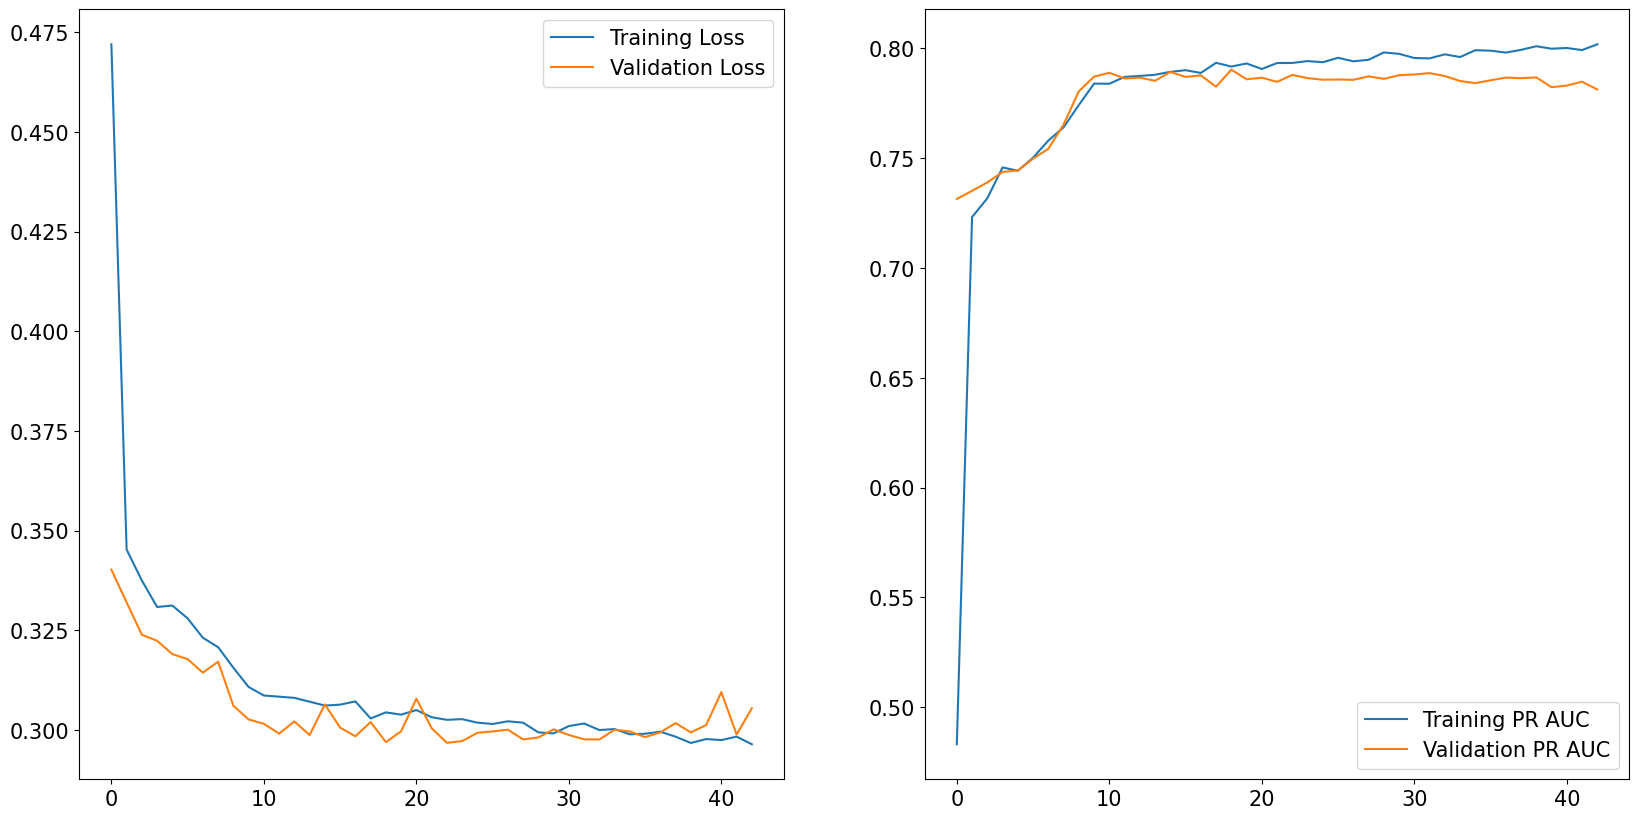

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(ft_linear_history.history['loss'], label='Training Loss')
ax[0].plot(ft_linear_history.history['val_loss'], label='Validation Loss')
ax[0].legend()

ax[1].plot(ft_linear_history.history['output_PR AUC'], label='Training PR AUC')
ax[1].plot(ft_linear_history.history['val_output_PR AUC'], label='Validation PR AUC')
ax[1].legend()

plt.show()

In [20]:
linear_test_preds = ft_linear_transformer.predict(test_dataset)
print("FT-Transformer with Linear Numerical Embedding")
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], linear_test_preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], linear_test_preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], linear_test_preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

32/32 [==============================] - 10s 212ms/step
FT-Transformer with Linear Numerical Embedding
Test ROC AUC: 0.9101
Test PR AUC: 0.7774
Test Accuracy: 0.8557


In [22]:
test_dataset

<_PrefetchDataset element_spec={'age': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'education_num': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'capital_gain': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'capital_loss': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'hours_per_week': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'workclass': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'education': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'marital_status': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'occupation': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'relationship': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'race': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'gender': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'native_country': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'income_bracket': TensorSpec(shape=(No

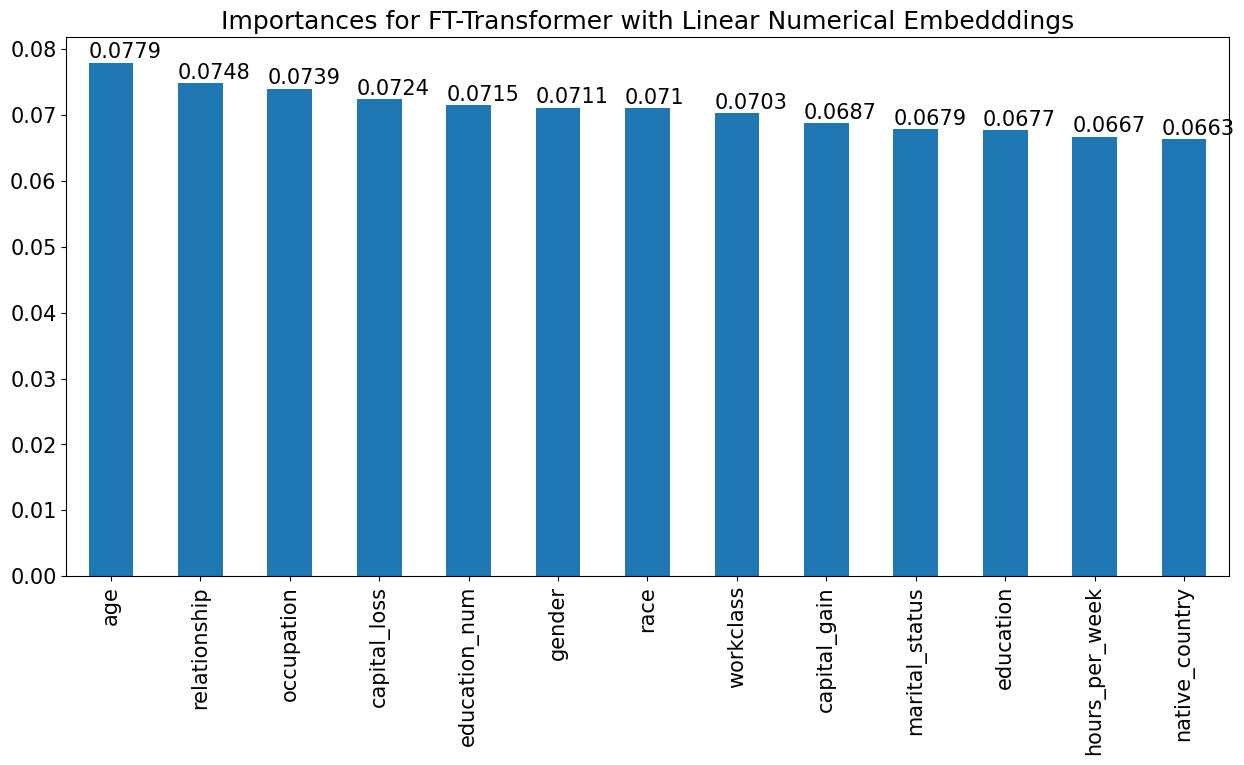

In [27]:
# Utility function
def get_model_importances(importances, title="Importances"):
    imps_sorted = importances.mean().sort_values(ascending=False)

    plt.figure(figsize=(15,7))
    ax = imps_sorted.plot.bar()
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(), 4)), (p.get_x(), p.get_height() * 1.01))
    plt.title(title)
    plt.show()

    return imps_sorted

# Model output
linear_importances = linear_test_preds['importances']

# Exclude attention from CLS token to CLS token
linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)

# Plot and store
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)


In [26]:
linear_test_preds['importances'][:,:-1]

array([[0.07807785, 0.07589176, 0.06214237, ..., 0.06367943, 0.06773044,
        0.06782585],
       [0.07763769, 0.07276545, 0.06914503, ..., 0.06685867, 0.06414545,
        0.0686954 ],
       [0.07330682, 0.06804108, 0.06046812, ..., 0.07836868, 0.06366089,
        0.06662425],
       ...,
       [0.08065663, 0.07001543, 0.07539605, ..., 0.08266045, 0.06313582,
        0.06552672],
       [0.0743611 , 0.07099751, 0.06711756, ..., 0.07236795, 0.12812276,
        0.06318063],
       [0.08008038, 0.07634038, 0.07427338, ..., 0.08092967, 0.06412651,
        0.06482358]], dtype=float32)

In [25]:
linear_test_preds['importances'][:,:]

array([[0.07807785, 0.07589176, 0.06214237, ..., 0.06773044, 0.06782585,
        0.08729173],
       [0.07763769, 0.07276545, 0.06914503, ..., 0.06414545, 0.0686954 ,
        0.07174078],
       [0.07330682, 0.06804108, 0.06046812, ..., 0.06366089, 0.06662425,
        0.08416079],
       ...,
       [0.08065663, 0.07001543, 0.07539605, ..., 0.06313582, 0.06552672,
        0.06833316],
       [0.0743611 , 0.07099751, 0.06711756, ..., 0.12812276, 0.06318063,
        0.0704296 ],
       [0.08008038, 0.07634038, 0.07427338, ..., 0.06412651, 0.06482358,
        0.0683957 ]], dtype=float32)

## Explainability

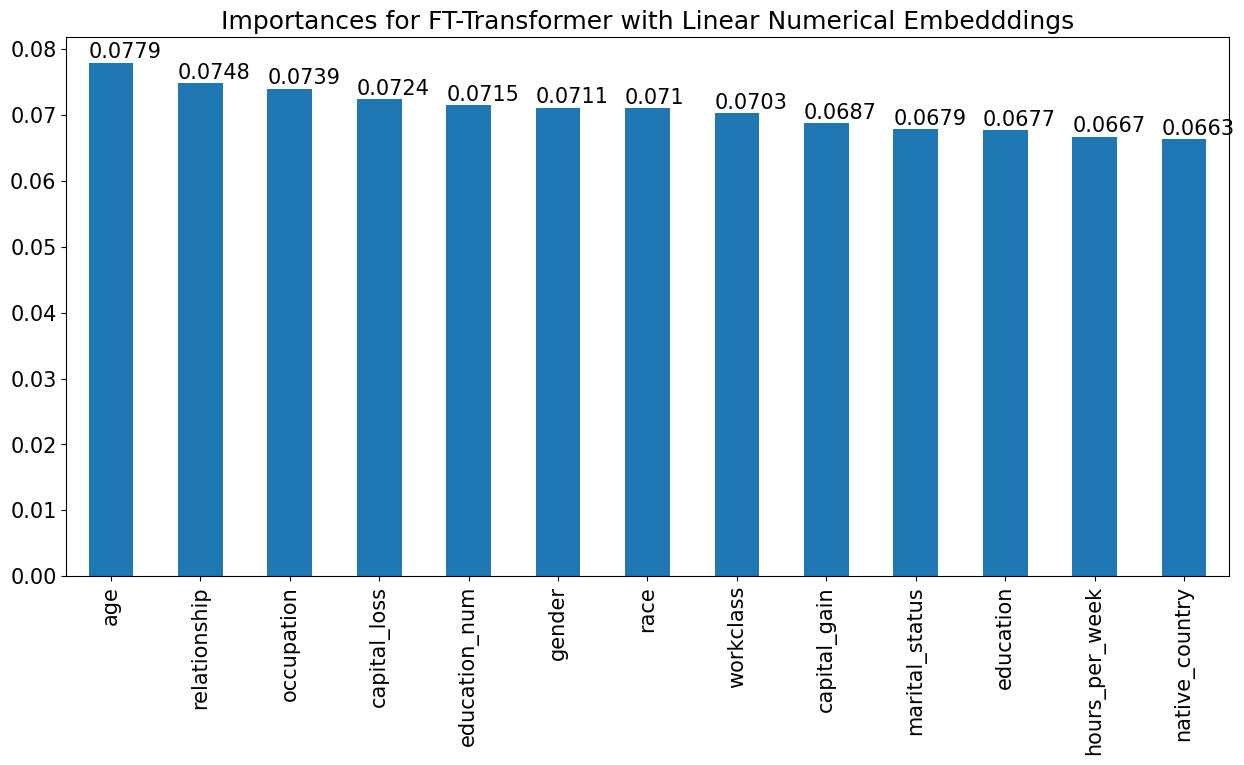

In [28]:
linear_importances = linear_test_preds['importances']
linear_importances_df = pd.DataFrame(linear_importances[:, :-1], columns = FEATURES)
linear_total_importances = get_model_importances(
    linear_importances_df, title="Importances for FT-Transformer with Linear Numerical Embedddings"
)

In [36]:
ft_linear_encoder.

Top 5 contributions to row 10078 which was scored 0.9888


,Importance,Example Vlaue
gender,0.151534,Male
age,0.083795,0.46772
occupation,0.080288,Sales
hours_per_week,0.077876,1.184493
education,0.074487,Doctorate


Top 5 contributions to row 12155 which was scored 0.003


,Importance,Example Vlaue
age,0.078549,-0.556801
relationship,0.075748,Other-relative
occupation,0.074413,Adm-clerical
education_num,0.073450,-0.4213
marital_status,0.070814,Never-married


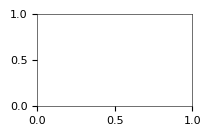

In [39]:
# Largest prediction
max_idx = np.argsort(linear_test_preds['output'].ravel())[-1]
example_importance_linear = linear_importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    test_data.iloc[max_idx, :].rename("Example Vlaue")
).head(5)
print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(linear_test_preds['output'].ravel()[max_idx], 4))}")
display(example_importance_linear)

# Smallest one
min_idx = np.argsort(linear_test_preds['output'].ravel())[0]
example_importance_linear = linear_importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
    test_data.iloc[min_idx, :].rename("Example Vlaue")
).head(5)
print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(linear_test_preds['output'].ravel()[min_idx], 4))}")
display(example_importance_linear)

In [38]:
test_data.iloc[2,:]

age                         -0.776341
workclass                   Local-gov
fnlwgt                       336951.0
education                  Assoc-acdm
education_num                0.744785
marital_status     Married-civ-spouse
occupation            Protective-serv
relationship                  Husband
race                            White
gender                           Male
capital_gain                -0.145355
capital_loss                -0.216681
hours_per_week              -0.034223
native_country          United-States
income_bracket                      1
Name: 3, dtype: object